# End-to-end multi-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.5.0 and TensorFlow Hub.

## 1. Problem
Identifing the breed of dog using a given image of the dog.
When I'm sitting in a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data that we are using is from Kaggle's Dog Breed Identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

## 4. Features
Some information about the data:
* We're dealing with images (unstructured data), so it's probably best we use Deep Learning / Transfer Learning.
* There are 120 breeds of dogs (This means there are 120 different classes.
* There are around 10,000+ images in the training set (These images have labels).
* There around 10,000+ images in the test set (these images will have no labels, because we want to predict them).



In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import tensorflow as tf
print("TF version:",tf.__version__)
import tensorflow_hub as hub
print("TF HUB version: ",hub.__version__)

TF version: 2.9.2
TF HUB version:  0.12.0


In [4]:
#!unzip "/content/drive/MyDrive/Dog vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Dog vision/"

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### If above code shows empty list. GPU might be disbaled.
### To activate GPU:


*   Go to "Runtime Tab"
*   Select "Change Runtime Type"
*   Choose "HardWare accelerator" as GPU and save



# Getting our data ready
As all machine learning models works with numbers rather than string and images.   
We will read the data and then turn data to numerical formats


In [6]:
labels_csv=pd.read_csv("/content/drive/MyDrive/Dog vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Visualizing data

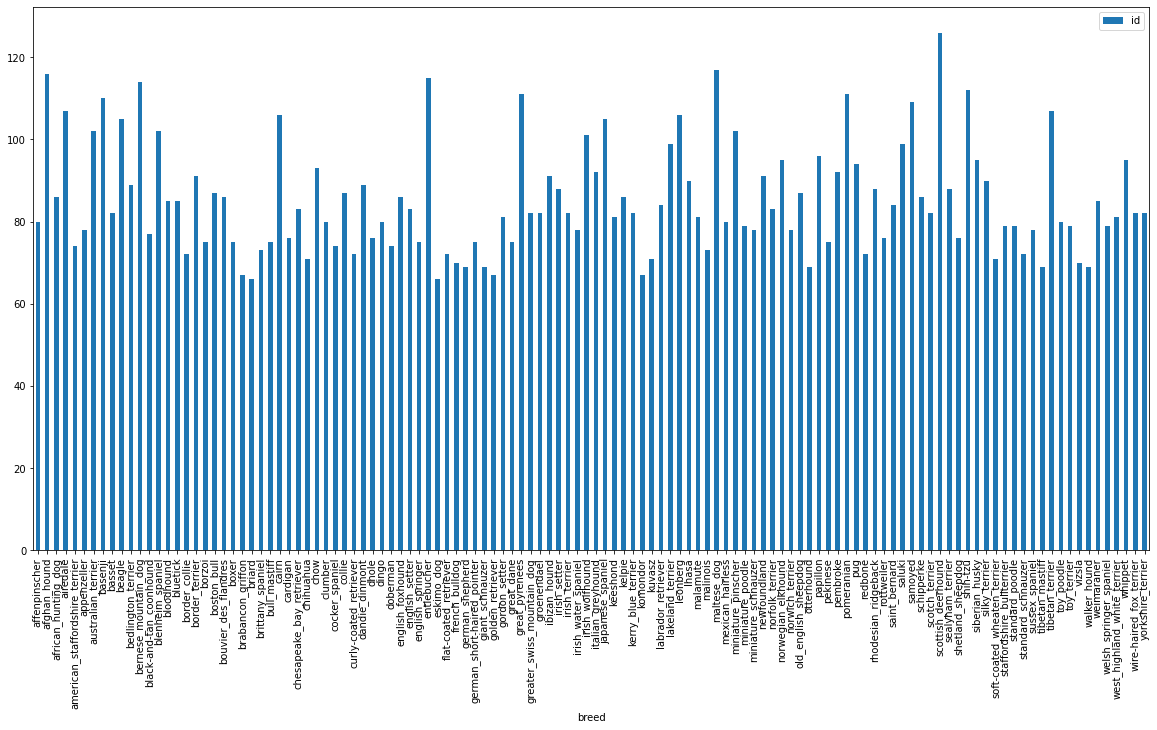

In [8]:
# Data distribution according to breed
df=labels_csv.groupby(['breed']).count().plot.bar(figsize=(20,10))

In [9]:
labels_csv['breed'].value_counts().median()

82.0

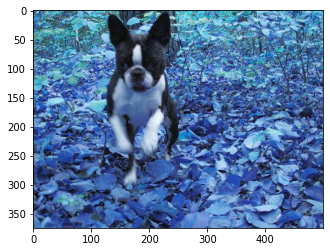

In [10]:
# A model image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
img=cv.imread('/content/drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg')
plt.imshow(img)


## Getting images and their labels
Let's get a list of all images pathnames

In [11]:
#Creating file names with image IDs
filenames = ['/content/drive/MyDrive/Dog vision/train/'+fname + '.jpg' for fname in labels_csv['id']]
filenames

['/content/drive/MyDrive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 '/content/drive/MyDrive/Dog vision/train/004396df1acd0f1247b740ca2b14616e.jpg',
 '/content/drive/MyDrive/Dog vision/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 '/content/drive/MyDrive/Dog

Now we've got image filepaths next thing is to prepare labels

In [12]:
labels=labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
# Check for missing data
if(len(filenames)==len(labels) and ~labels_csv['breed'].isna().sum()):
  print('No missing data')
else:
  print('Missing data are there')

No missing data


### Turning labels into numbers

In [14]:
#Findin unique labels
unique_breeds=np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [15]:
# One Hot Encoding labels

# For a single label `True` if the label is unique_breeds else false
print(unique_breeds[0])
labels[0] == unique_breeds


affenpinscher


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# For all unique labels
bool_one_hot=np.array([label==unique_breeds for label in labels])
one_hot=bool_one_hot.astype(int)
one_hot[:2]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [17]:
# Checking one hot encoder
print(labels[0])
print(bool_one_hot[0].argmax())
print(one_hot[0].argmax())
print(one_hot[0])

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating validation set

In [18]:
X = filenames
y = one_hot

In [19]:
len(filenames)

10222

There are more than 10000 images. Training that much images will be too slow. So lets try with some 1000 images and then we can increase the number of images

In [20]:
#Setting number of imates
NUM_IMAGES= 1000 #@param {type: "slider",min:1000,max:10000,steps:1000}

In [21]:
# Using train test split to generate validation set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X[:NUM_IMAGES],
                                                 y[:NUM_IMAGES],
                                                 test_size=0.2,
                                                 random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocessing images (turning into tensors)

We will create a function to preprocess images which will do the following:
1. Take an image filepath as input
2. Read the image file and save it into variable `image`
3. Turn `image` into Tensors
4. Making standard size of `image` to shape (224,224)
5. Return `image`

In [22]:
# Standard image size
IMG_SIZE = 224

# Function to preprocess images
def preprocess_image(filepath, img_size=IMG_SIZE):
  #Read image from filepath
  image = tf.io.read_file(filepath)
  # Converting image into Tensors with 3 colour channels (R,G,B)
  image = tf.image.decode_jpeg(image,channels=3)
  #print(image)
  # Range normalization of colour channels form 0-255 to 0-1
  image = tf.image.convert_image_dtype(image,tf.float32)
  #print(image)
  # Resizing image to standard size
  image = tf.image.resize(image, size=[img_size,img_size])
  return image

In [23]:
preprocess_image(filenames[0])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.5705322 , 0.33588538, 0.15008473],
        [0.66901225, 0.4601166 , 0.26022965],
        [0.61062384, 0.43763596, 0.21601713],
        ...,
        [0.8182312 , 0.7297958 , 0.26963907],
        [0.72454786, 0.6059109 , 0.2653059 ],
        [0.7494603 , 0.6252918 , 0.32456532]],

       [[0.6761415 , 0.4733761 , 0.30642927],
        [0.5672121 , 0.38192675, 0.20349538],
        [0.5883547 , 0.4322571 , 0.2403155 ],
        ...,
        [0.9326942 , 0.8260503 , 0.41093278],
        [0.86072475, 0.74250627, 0.3694122 ],
        [0.76781666, 0.6461604 , 0.29291284]],

       [[0.46350825, 0.29595745, 0.1536156 ],
        [0.42554107, 0.27039403, 0.12009468],
        [0.7887875 , 0.6547362 , 0.49015   ],
        ...,
        [0.89372385, 0.7696401 , 0.41811958],
        [0.88609535, 0.7585918 , 0.36495727],
        [0.8243601 , 0.69494826, 0.2930575 ]],

       ...,

       [[0.7344025 , 0.4716574 , 0.2559711 ],
        [0.71

In [24]:
# Function to make image label tensors  pair
def img_label_pair(filepath,label):
  img=preprocess_image(filepath)
  return (img,label)

Now, turn all images into tensors along with the corresponding labels

In [25]:
# Dividing data into batches using BATCH_SIZE
BATCH_SIZE=32

#Function to turn data into batches
def create_batches(X, y=None, batch_size=BATCH_SIZE, train_data=False, valid_data=False, test_data=False):

  # If data is test data
  if test_data:
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch=data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch

  # If data is train data
  elif train_data:
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch=data.map(img_label_pair).batch(BATCH_SIZE)
    return data_batch
  
  # If data is valid data
  else:
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch=data.map(img_label_pair).batch(BATCH_SIZE)
    return data_batch

In [26]:
# Creating training and validation set batches
train_data = create_batches(X_train,y_train,train_data=True)
val_data = create_batches(X_val,y_val,valid_data=True)

In [27]:
train_data , val_data

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.int64, name=None))>)

## Visualizing and checking Data Batches

In [28]:
def show_images(images,labels=None):
  # Display a sample of images
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis('off')

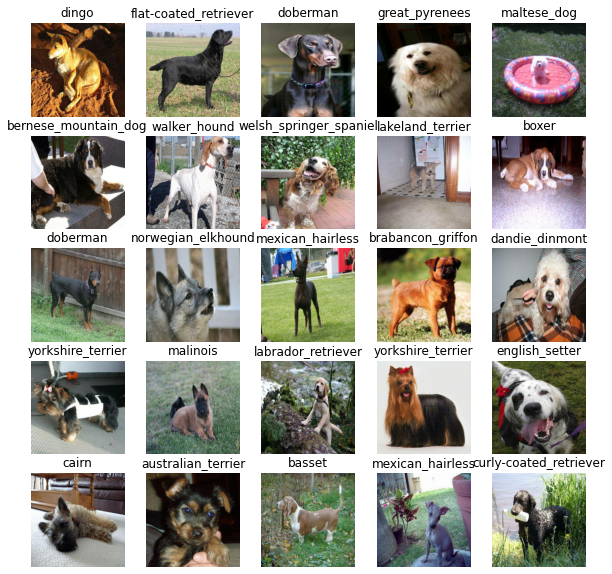

In [29]:
# Visualizing train data
images, labels = next(train_data.as_numpy_iterator())
show_images(images, labels)

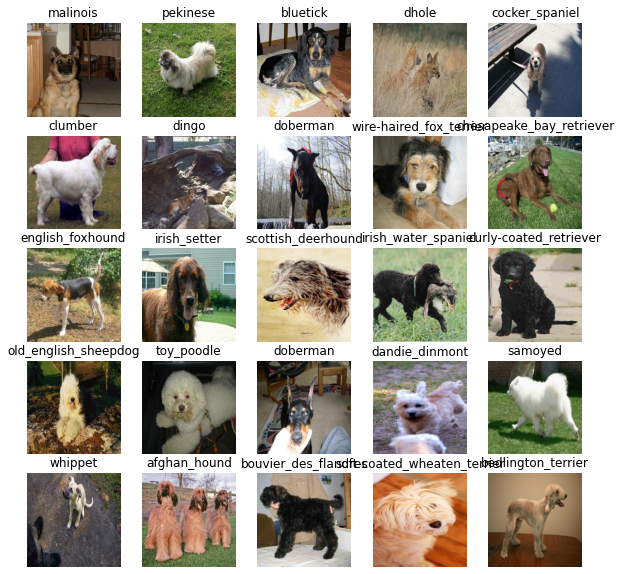

In [30]:
# Visualizing validation data
images, labels = next(val_data.as_numpy_iterator())
show_images(images, labels)

## Building model
Now that data is ready after preprocessing we need to create a model.

We will use transfer learning i.e. to use a pretrained model for image classification and use the trained weights to train our model.   

Since we know our problem is image classification (classifying different dog breeds), we can navigate the [TensorFlow Hub](https://tfhub.dev/s?module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent) page by our problem domain (image).   
We will be using [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5) model for classification.   
 [mobilenet_v2_130_224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5) takes an input of images in the shape 224, 224. It also says the model has been trained in the domain of image classification.
So  mobilenet_v2_130_224 fits the purpose.

In [31]:
# Model parameters

INPUT_SHAPE = [None, IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL='https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'
print('INPUT_SHAPE: ', INPUT_SHAPE)
print('OUTPUT_SHAPE: ', OUTPUT_SHAPE)
print('MODEL_URL: ', MODEL_URL)

INPUT_SHAPE:  [None, 224, 224, 3]
OUTPUT_SHAPE:  120
MODEL_URL:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [32]:

# Creating a keras building function
def create_model(input_shape=INPUT_SHAPE, output_shape= OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", MODEL_URL, "using Transfer Learning for classification")

  # Setup of model layers
  model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),
        tf.keras.layers.Dense(units=output_shape, activation='softmax')
  ])

  # Compile model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.SGD(),
      metrics=['accuracy']
  )

  model.build(input_shape)

  return model


In [33]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5 using Transfer Learning for classification
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [34]:
%load_ext tensorboard

In [35]:
import datetime
import os

def create_tensorboard_callback():
  logdir=os.path.join("drive/MyDrive/Dog Vision/logs",
                      #Make sure logs get tracked whenever we run an experiment
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                      )
  return tf.keras.callbacks.TensorBoard(logdir)

### Adding early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a cetain evaluation matrix stops improving. 

https://keras.io/api/callbacks/early_stopping/



In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [37]:
EPOCHS=100

In [38]:
def train_model():
  # Function to train model and returns trained model
  model=create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data,
            epochs=EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  return model

In [39]:
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5 using Transfer Learning for classification
Epoch 1/100
25/25 [==============================] - 136s 5s/step - loss: 5.1478 - accuracy: 0.0200 - val_loss: 4.6507 - val_accuracy: 0.0600
Epoch 2/100
25/25 [==============================] - 4s 152ms/step - loss: 4.0375 - accuracy: 0.1088 - val_loss: 3.9659 - val_accuracy: 0.1250
Epoch 3/100
25/25 [==============================] - 4s 157ms/step - loss: 3.1581 - accuracy: 0.2925 - val_loss: 3.4335 - val_accuracy: 0.2650
Epoch 4/100
25/25 [==============================] - 3s 130ms/step - loss: 2.4832 - accuracy: 0.4712 - val_loss: 3.0303 - val_accuracy: 0.3300
Epoch 5/100
25/25 [==============================] - 3s 134ms/step - loss: 1.9818 - accuracy: 0.5962 - val_loss: 2.7145 - val_accuracy: 0.3850
Epoch 6/100
25/25 [==============================] - 4s 153ms/step - loss: 1.6047 - accuracy: 0.6938 - val_loss: 2.4685 - val_accuracy: 0.4200
Epoch 

# Making and evaluating predictions using a trained model


In [40]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 3s 99ms/step


array([[2.9672679e-04, 6.5513559e-05, 6.6881359e-05, ..., 5.4990954e-04,
        1.0365908e-05, 3.7331402e-04],
       [5.9714384e-05, 4.1543238e-04, 6.9566151e-05, ..., 9.3212712e-04,
        5.9326162e-04, 4.1257132e-05],
       [4.2888409e-05, 1.1838758e-03, 2.9521150e-04, ..., 2.3493671e-05,
        2.6296172e-04, 1.2505889e-05],
       ...,
       [6.4748009e-03, 1.1598065e-03, 6.1670248e-03, ..., 1.5065111e-03,
        3.5147733e-04, 4.4776122e-03],
       [7.6201650e-05, 2.3539807e-05, 3.0693092e-05, ..., 9.4477745e-04,
        7.5262673e-03, 2.5511181e-04],
       [2.1074602e-04, 1.3834935e-05, 1.2877807e-03, ..., 2.7553455e-04,
        1.3503789e-03, 3.3668157e-02]], dtype=float32)

In [41]:
predictions.shape
predictions[0]

array([2.96726794e-04, 6.55135591e-05, 6.68813591e-05, 7.29597150e-06,
       1.12773261e-04, 2.99583160e-04, 7.12990004e-05, 4.87903785e-03,
       8.41575365e-06, 1.81883825e-05, 9.96666402e-03, 9.39093734e-05,
       3.21903826e-05, 2.71948084e-04, 4.11109704e-06, 1.10218789e-04,
       2.97303079e-04, 1.31047209e-05, 5.85601010e-05, 1.40276621e-04,
       2.54914885e-05, 5.62047178e-04, 2.21684786e-05, 1.62410633e-05,
       4.52270979e-05, 2.07245219e-04, 2.75559170e-04, 3.23420361e-04,
       8.83443805e-04, 4.48508625e-04, 6.60939782e-04, 1.74701985e-04,
       6.72646420e-05, 2.29151919e-05, 1.83729950e-04, 4.17803135e-03,
       4.02085570e-05, 3.36538033e-05, 3.89895722e-05, 1.85977799e-04,
       8.02171562e-05, 4.05426454e-06, 3.66662289e-06, 1.19936559e-03,
       8.63152127e-06, 2.23847790e-04, 9.04885019e-05, 4.24600330e-05,
       2.03288888e-04, 1.15960673e-03, 1.70195963e-05, 1.13215030e-03,
       2.93264259e-03, 2.61836740e-05, 6.14578428e-04, 9.20471120e-06,
      

In [42]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum:{np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[2.96726794e-04 6.55135591e-05 6.68813591e-05 7.29597150e-06
 1.12773261e-04 2.99583160e-04 7.12990004e-05 4.87903785e-03
 8.41575365e-06 1.81883825e-05 9.96666402e-03 9.39093734e-05
 3.21903826e-05 2.71948084e-04 4.11109704e-06 1.10218789e-04
 2.97303079e-04 1.31047209e-05 5.85601010e-05 1.40276621e-04
 2.54914885e-05 5.62047178e-04 2.21684786e-05 1.62410633e-05
 4.52270979e-05 2.07245219e-04 2.75559170e-04 3.23420361e-04
 8.83443805e-04 4.48508625e-04 6.60939782e-04 1.74701985e-04
 6.72646420e-05 2.29151919e-05 1.83729950e-04 4.17803135e-03
 4.02085570e-05 3.36538033e-05 3.89895722e-05 1.85977799e-04
 8.02171562e-05 4.05426454e-06 3.66662289e-06 1.19936559e-03
 8.63152127e-06 2.23847790e-04 9.04885019e-05 4.24600330e-05
 2.03288888e-04 1.15960673e-03 1.70195963e-05 1.13215030e-03
 2.93264259e-03 2.61836740e-05 6.14578428e-04 9.20471120e-06
 1.14692171e-04 1.50100954e-04 4.07322124e-03 9.69918910e-05
 4.64447774e-03 2.66194169e-04 5.69925760e-04 7.55193469e-05
 2.38909110e-04 3.884990

### Transforming predictions from probabilities to label(dog-breed)



In [43]:
def get_pred_label(predictions):
  return unique_breeds[np.argmax(predictions)]

pred_label = get_pred_label(predictions[0])

### Now to make predictions on test data validation set needs to be unbatched and return the predicted labels

In [44]:
def unbatch(data):
  images = []
  labels = []
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images,labels

In [47]:
# Unbatchify the validation dataset
val_images_, val_labels_ = unbatch(val_data)
val_images_[0], val_labels_[0], get_pred_label(val_labels_[0])

(array([[[0.6918335 , 0.687912  , 0.6722257 ],
         [0.6539495 , 0.65002793, 0.63434166],
         [0.6396931 , 0.6357715 , 0.62008524],
         ...,
         [0.9799891 , 0.9833243 , 0.9525382 ],
         [0.9854699 , 0.98939145, 0.9580189 ],
         [0.8570352 , 0.8609568 , 0.82958424]],
 
        [[0.6797994 , 0.6758778 , 0.66019154],
         [0.6214773 , 0.61755574, 0.60186946],
         [0.6161034 , 0.61218184, 0.59649557],
         ...,
         [0.9799891 , 0.9833243 , 0.95915586],
         [0.9883978 , 0.9923193 , 0.9675644 ],
         [0.8711903 , 0.8751119 , 0.85035694]],
 
        [[0.67957675, 0.6756552 , 0.6599689 ],
         [0.6182995 , 0.6143779 , 0.59869164],
         [0.62655133, 0.62262976, 0.6069435 ],
         ...,
         [0.976654  , 0.9799891 , 0.95704615],
         [0.9953992 , 0.99661595, 0.9757914 ],
         [0.8927772 , 0.8966988 , 0.87316936]],
 
        ...,
 
        [[0.65533966, 0.68279064, 0.7220063 ],
         [0.63134164, 0.6587926 , 0.69800